# Planning Methods: Part II, Spring 2021

# Lab 4: Multicollinearity & Homoskedasticity

**About This Lab**

*DISCLAIMER: WE HAVE NOT COVERED THIS TOPIC IN CLASS. OUR NEXT TWO CLASSES WILL COVER THIS. THE EMPHASIS OF THIS LAB IS ON THE MECHANICS OF DETECTING THESE PROBLEMS.

* We will be running through this notebook together. If you have a clarifying question or other question of broad interest, feel free to interrupt or use a pause to unmute and ask it! If you have a question that may result in a one-on-one breakout room (think: detailed inquiry, conceptual question, or help debugging), please ask it in the chat!
* We recognize learning Python via Zoom comes with its challenges and that there are many modes of learning. Please go with what works best for you. That might be printing out the Jupyter notebook, duplicating it such that you can refer to the original, working directly in it. Up to you! There isn't a single right way.
* This lab requires that you download the following file and place it in the same directory as this Jupyter notebook:
    * `clean_property_data.csv`
* This data includes properties that were sold through a real estate site (like Zillow) between 2001 and 2006 in Bogota. There are apartments and houses, characteristics of the structure like area and bathrooms, and characteristics of the neighborhood like density and a proxy for neighborhood income which is called ses.

## Objectives
By the end of this lab, you will have reviewed how to:
>1. Call a correlation matrix
>2. Run multivariable linear regression

You will also learn how to:
>1. Use a and interpret the Variance Inflation Factor (VIF)
>2. Calculate predicted values using regression model 
>3. Detect heteroskedasticity using plots 
>4. Detect heteroskedasticity using the Breusch-Pagan test
>5. Use robust errors if needed

### 1. Import packages and  read the data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from statsmodels.compat import lzip

In [3]:
#Read in your data 
data = pd.read_csv('clean_property_data.csv')

#Explore your data
data.head()

,id,price_000,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,apt,floor,...,pcnt_indu,pcnt_com,pcnt_insti,pcnt_vacant,pcn_green,thefts,house,ses_bin,lnprice,price_hi
0,40003,60000,1,0,0,0,0,0,1,5,...,0.0,0.00,0.49,0.0,1.74,39.92,0,0,11.00210,0
1,40007,140000,0,1,0,0,0,0,0,0,...,0.0,15.41,1.32,0.0,0.54,46.00,1,0,11.84940,1
2,40008,38000,0,1,0,0,0,0,1,1,...,0.0,8.16,5.57,0.0,1.55,45.87,0,0,10.54534,0
3,40010,110000,0,1,0,0,0,0,0,0,...,0.0,8.11,5.53,0.0,1.58,45.88,1,0,11.60824,1
4,40011,120000,0,1,0,0,0,0,0,0,...,0.0,0.00,0.00,0.0,0.40,46.00,1,0,11.69525,1


In [4]:
#Create a subdataframe, create a binary variable called 'high_ses', and explore your dataframe
df = data[['price_000', 'ses', 'pop_dens', 'area_m2',
          'num_bath', 'pcn_green', 'thefts', 'house']].copy()
df['high_ses'] = np.where((df['ses'] >= 5), 1,0)
df.head()

,price_000,ses,pop_dens,area_m2,num_bath,pcn_green,thefts,house,high_ses
0,60000,4,830.78,70,2,1.74,39.92,0,0
1,140000,4,826.75,257,4,0.54,46.00,1,0
2,38000,4,914.15,115,4,1.55,45.87,0,0
3,110000,4,911.25,270,4,1.58,45.88,1,0
4,120000,4,757.37,268,2,0.40,46.00,1,0


### 2. Estimate a multivariable linear regression

We will first run a multivariable linear regression similar to the one we used in Lab 3. In the later sections, we will evaluate our results by checking for multicollinearity and heteroskedasticity.

In [5]:
#Define a list of independent variables of interest 
ind_var = ['high_ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 'thefts','pop_dens']

#Define our explanatory and dependent variables 
x = df[ind_var].assign(Intercept = 1)
y = df['price_000']

#Let's save the results of the regression as model.
#This is be helpful for functions we will use below 
model = sm.OLS(y, x).fit()

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.517     
Dependent Variable:   price_000         AIC:                 97714.7913
Date:                 2021-02-17 13:40  BIC:                 97765.0955
No. Observations:     3976              Log-Likelihood:      -48849.   
Df Model:             7                 F-statistic:         609.1     
Df Residuals:         3968              Prob (F-statistic):  0.00      
R-squared:            0.518             Scale:               2.7539e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
high_ses   70994.9141 3191.5051  22.2450 0.0000  64737.7704  77252.0577
house     -27823.6816 2443.3460 -11.3875 0.0000 -32614.0129 -23033.3503
area_m2      571.9391   14.4755  39.5109 0.0000    543.5590    600.3192
num_bath   10065.8898  956.4128  10.5246 0.0000   8190.7832  11940.9964
pcn_green    226.9919  116.3051   1.9517 0.0510     -1.0315    455.0153
thefts       -16.5332   16.3687  -1.0101 0.3125    -48.6250     15.5586
pop_dens     -12.1673    3.6363  -3.3461 0.0008    -19.2964     -5.0381
Intercept  11441.8878 2818.5459   4.0595 0.0001   5915.9537  16967.8219
-----------------------------------------------------------------------
Omnibus:              3096.246       Durbin-Watson:          0.908     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       120267.662
Skew:                 3.367          Prob(JB):               0.000     
Kurtosis:             29.089         Condition No.:          2151      
=======================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

### 3. Multicollinearity 

*THIS HAPPENS WHEN ONE OR MORE INDEPENDENT VARIABLES ARE CLOSELY RELATED WITH EACH OTHER. AS A RESULT, THE VARIABLE(S) DO NOT ADD INFORMATION TO YOUR ABILITY TO MAKE A BETTER GUESS ABOUT THE DEPENDENT VARIABLE. AS A RESULT, THE ESTIMATED COEFFICIENT HAS A LOT OF ERROR (THAT IS, THE T-STATISTIC IS LOW, THE P-VALUE IS HIGH, AND THE 95% CONFIDENCE INTERVAL INCLUDES ZERO).

*YOU RUN THIS TEST AS A WAY TO MAKE SURE THAT MULTICOLLINEARITY IS NOT RENDERING ONE OR MORE OF YOUR COEFFICIENTS AS INSIGNIFICANT.

*IF MULTICOLINEARITY IS HIGH, THEN YOU KNOW WHY YOUR COEFFICIENT IS NOT SIGNIFICANT. IF IT IS LOW, IT MUST BE SOMETHING ELSE...

#### 3.1 Correlation Matrix

We will first use a correlation matrix to examine multicollinearity. We would like to know if any of our explanatory variables are highly correlated to one another as this might affect our regression. Let's do this using `ind_var`.

In [6]:
#Call up your correlation matrix 
df[ind_var].corr()

,high_ses,house,area_m2,num_bath,pcn_green,thefts,pop_dens
high_ses,1.000000,-0.100795,0.102760,0.099413,-0.015300,-0.109577,-0.095480
house,-0.100795,1.000000,0.651771,0.391207,-0.071164,0.002256,0.186380
area_m2,0.102760,0.651771,1.000000,0.530402,-0.081659,-0.155758,0.169518
num_bath,0.099413,0.391207,0.530402,1.000000,0.004428,-0.023408,0.085829
pcn_green,-0.015300,-0.071164,-0.081659,0.004428,1.000000,0.400809,-0.030906
thefts,-0.109577,0.002256,-0.155758,-0.023408,0.400809,1.000000,0.122644
pop_dens,-0.095480,0.186380,0.169518,0.085829,-0.030906,0.122644,1.000000


#### 3.2 Variance Inflation Factor (VIF)

The VIF is a better way of detecting multicollinearity because it checks whether combinations of independent variables, in addition to each one, help explan the other independent variables. By contrast, the correlation matrix above only shows us pairwise correlations. It is possible that two variables (for example, house and # of baths, more closely predicts the area of a property than house or # of baths independently.  

How does the VIF work? By regressing each independent variable on all others. Python (and stata and R) does this automatically.  For the model above, it runs 7 regressions (there are 7 independent variables).  In each regression, a different independent variable becomes DEPENDENT, while all others remain independent. For example:

Reg 1: Dependent: high_ses; independent: All other independent variables
Reg 2: Dependent: house; indepdendent: All other independent variables
:
:
Reg 7: Dependent: pop_dens; indepdendent: All other independent variables


If the R2 in each regression is high, it means that all other independent variables explain the new dependent variable very well, so the new dependent variable does not bring much new information to the original regression model. That variable would have a high VIF.

Formally, the VIF for each variable i is:
VIF = 1/(1-R2), where R2 is the model where i is the dependent variable.

A VIF of 5 or greater can be problematic, suggesting that high colinearity may be the reason for the lack of significance in your coefficient. (Note: For a given independent variable, a VIF of 5 means that the R2 of the regression equation with that variable as dependent and all other as independent is 0.8 or 80%. That is, 80% of the variation in that variable is explained by all other independent variables. In other words, only 20% of the variation in the variable is unique to it, and hence its possible limited explanatory power. A higher VIF (e.g., 10) means a higher R2 for the regression witth that variable as dependent and all other as independent (e.g., R2 of 0.9 or 90%).

In terms of the commands below, it is important to note that VIF does not detect dataframes, therefore we extract the values of x using `df.values` into an array. You could also use `np.array` to do this. 

In [7]:
#Let's verify the type of x in python
print(type(x))
x.head()

<class 'pandas.core.frame.DataFrame'>


,high_ses,house,area_m2,num_bath,pcn_green,thefts,pop_dens,Intercept
0,0,0,70,2,1.74,39.92,830.78,1
1,0,1,257,4,0.54,46.00,826.75,1
2,0,0,115,4,1.55,45.87,914.15,1
3,0,1,270,4,1.58,45.88,911.25,1
4,0,1,268,2,0.40,46.00,757.37,1


In [8]:
#We will now obtain an array of our x values 
x_array = x.values

#Let's verify the type of x_array
print(type(x_array))
x_array

<class 'numpy.ndarray'>


array([[  0.  ,   0.  ,  70.  , ...,  39.92, 830.78,   1.  ],
       [  0.  ,   1.  , 257.  , ...,  46.  , 826.75,   1.  ],
       [  0.  ,   0.  , 115.  , ...,  45.87, 914.15,   1.  ],
       ...,
       [  0.  ,   0.  , 145.  , ..., 234.  , 374.17,   1.  ],
       [  1.  ,   0.  , 175.  , ..., 234.  , 320.5 ,   1.  ],
       [  1.  ,   0.  ,  87.  , ...,  52.  , 557.36,   1.  ]])

In [9]:
# We will now obtain a VIF for each of the coefficients in our model 
vif = [variance_inflation_factor(x_array, i) for i in range(x.shape[1])]
vif

[1.0821175392035043,
 1.8861477501052755,
 2.243558064422289,
 1.4138139507813046,
 1.209931913585162,
 1.2852849296361972,
 1.0762714385994052,
 11.469791395454084]

Wow! What are these numbers?! What is going on? Let's add some labels to the data.

In [10]:
#Let's label the VIF values that we obtained 
pd.Series(vif, index = x.columns)

high_ses      1.082118
house         1.886148
area_m2       2.243558
num_bath      1.413814
pcn_green     1.209932
thefts        1.285285
pop_dens      1.076271
Intercept    11.469791
dtype: float64

We can also obtain the VIF for a particular explanatory variable. Let's explore these steps a little 

In [11]:
#We now will calculate the shorthand VIF for 'high_ses'
#Create a sub-dataframe of your independent variables 
sub_ind = ['house', 'area_m2', 'num_bath', 'pcn_green', 'thefts', 'pop_dens']

#Let's define our x and our y 
x = df[sub_ind].assign(Intercept = 1)
y = df['high_ses']

#Run your regression 
sm.OLS(y, x).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.074   
Dependent Variable: high_ses         AIC:                608.8785
Date:               2021-02-17 13:40 BIC:                652.8948
No. Observations:   3976             Log-Likelihood:     -297.44 
Df Model:           6                F-statistic:        54.32   
Df Residuals:       3969             Prob (F-statistic): 1.10e-64
R-squared:          0.076            Scale:              0.068119
------------------------------------------------------------------
              Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
------------------------------------------------------------------
house        -0.1600    0.0119  -13.4618  0.0000  -0.1833  -0.1367
area_m2       0.0008    0.0001   10.8017  0.0000   0.0006   0.0009
num_bath      0.0220    0.0047    4.6474  0.0000   0.0127   0.0313
pcn_green     0.0002    0.0006    0.3879  0.6981  -0.0009   0.0014
thefts       -0.0003    0.0001   -3.5488  0.0004  -0.0004  -0.0001
pop_dens     -0.0001    0.0000   -5.3770  0.0000  -0.0001  -0.0001
Intercept     0.0601    0.0140    4.2954  0.0000   0.0327   0.0875
-----------------------------------------------------------------
Omnibus:             2196.433     Durbin-Watson:        1.391    
Prob(Omnibus):       0.000        Jarque-Bera (JB):     12074.615
Skew:                2.757        Prob(JB):             0.000    
Kurtosis:            9.517        Condition No.:        1957     
=================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [12]:
#Let's now calculate the VIF using the formula VIF = 1/(1 - R^2)
vif_high_ses = 1/(1 - (0.076))
print(vif_high_ses)

1.0822510822510822


### 4. Predictions 
Remember that one way to determine how well our model fit is comparing our guesses (the prediction) with actual values. Here we calculate make this comparison by calculating the difference between observed and predicted for each row of data. These are called residuals. The purpose in this case, however, isn't to determine model fit but to make sure that the model is not violating a critical assumption: That residuals are not uniformly distributed 

Earlier we estimated a linear regression which calculates the association between our y (price), and our explanatory variables. The coefficients we obtain can help us draw a regression line for price in this way: 

y = 11441 + (70994 * high_ses) + (-27823 * house) + (571 * area_m2) +(10065 * num_bath) +  (226 * pcn_green) + (-16 * thefts) + (-12 * pop_dens)

Keep in mind that we saved the results of the linear regression under the "model" variable above:  
> model = sm.OLS(y, x).fit()

In [13]:
#Let's re-run the regression we obtained in part 2
x = df[ind_var].assign(Intercept = 1)
y = df['price_000']

model = sm.OLS(y, x).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.517     
Dependent Variable:   price_000         AIC:                 97714.7913
Date:                 2021-02-17 13:40  BIC:                 97765.0955
No. Observations:     3976              Log-Likelihood:      -48849.   
Df Model:             7                 F-statistic:         609.1     
Df Residuals:         3968              Prob (F-statistic):  0.00      
R-squared:            0.518             Scale:               2.7539e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
high_ses   70994.9141 3191.5051  22.2450 0.0000  64737.7704  77252.0577
house     -27823.6816 2443.3460 -11.3875 0.0000 -32614.0129 -23033.3503
area_m2      571.9391   14.4755  39.5109 0.0000    543.5590    600.3192
num_bath   10065.8898  956.4128  10.5246 0.0000   8190.7832  11940.9964
pcn_green    226.9919  116.3051   1.9517 0.0510     -1.0315    455.0153
thefts       -16.5332   16.3687  -1.0101 0.3125    -48.6250     15.5586
pop_dens     -12.1673    3.6363  -3.3461 0.0008    -19.2964     -5.0381
Intercept  11441.8878 2818.5459   4.0595 0.0001   5915.9537  16967.8219
-----------------------------------------------------------------------
Omnibus:              3096.246       Durbin-Watson:          0.908     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       120267.662
Skew:                 3.367          Prob(JB):               0.000     
Kurtosis:             29.089         Condition No.:          2151      
=======================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [14]:
#To simply look at the coefffients we obtained we can use the following:
model.params

high_ses     70994.914051
house       -27823.681617
area_m2        571.939109
num_bath     10065.889798
pcn_green      226.991890
thefts         -16.533236
pop_dens       -12.167251
Intercept    11441.887809
dtype: float64

We can now try to make a  prediction. Today, we will use the first line of observed data from our dataframe as seen below:

In [15]:
#Let's call our first line of x observations 
x.head(1)

,high_ses,house,area_m2,num_bath,pcn_green,thefts,pop_dens,Intercept
0,0,0,70,2,1.74,39.92,830.78,1


Our prediction will look like this:

y = 11441 + (70994 * 0) + (-27823 * 0) + (571 * 70) +(10065 * 2) +  (226 * 1.74)                   + (-16 * 39.92) + (-12 * 830.78)

In [16]:
#We can ask python to find the predicted value of y using this first line
#of our observed values
#We can do this using our dataframe x:
pred = model.predict(x.iloc[0].values)
print(pred)

#Or we can use our x_array:
pred1 = model.predict(x_array[0, :])
print(pred1)

[61236.05567787]
[61236.05567787]


In [17]:
#How does this value compare to the observed value of price in our dataset
#Let's call up the first line of the dataset
df.head(1)

,price_000,ses,pop_dens,area_m2,num_bath,pcn_green,thefts,house,high_ses
0,60000,4,830.78,70,2,1.74,39.92,0,0


In [18]:
#Let's now calculate the residual of our first prediction
model.resid[0]

-1236.055677868986

In [19]:
#We can also find the predictions and residuals for the entirety of our dataset
#Let's see what our predictions are
pred_mod = model.predict()
print(pred_mod)

#Let's see what our residuals are
res_mod = model.resid
print(res_mod)

[ 61236.05567787 160172.888774   105949.21029312 ... 106097.06034107
 205386.7188871  145478.21856861]
0        -1236.055678
1       -20172.888774
2       -67949.210293
3       -56818.020070
4       -27144.824365
            ...      
3971    195200.228799
3972    285090.710904
3973    458327.939659
3974    494413.281113
3975    554521.781431
Length: 3976, dtype: float64


### 4. Homoskedasticity

#### 4.1 Scedasticity Plots

Using the information we have gathered on our predicted values, and residuals, we can do a visual and a statistical test for homoskedasticity.

The visual test graphs the predicted values (also called fitted values) in the X-axis and the residuals in the Y-axis.

In [20]:
def homosked_plots(prediction, residuals):
    #Define the figure
    fig, ax = plt.subplots(figsize=(10,6))
    #Define x, and y 
    x = prediction
    y = residuals
    #Create title for your figure
    plt.title('Homokedasticity Test Plot')
    #Create your plot, and set your labels
    ax.scatter(x, y)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    #Formats axis number to include thousands separator
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))

    plt.show()

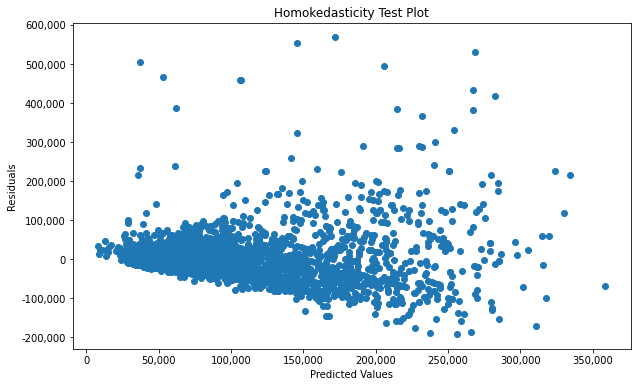

In [21]:
homosked_plots(pred_mod, res_mod)

#### 4.2 Breusch-Pagan Test

In [22]:
#Let's create a list of tests 
test_names = ['LMS', 'p-value', 'f-value', 'f p-value']

#Call the Breusch-Pagan test in python
results = sms.het_breuschpagan(model.resid, model.model.exog)

#Concatenate the test values to their names using lzip
lzip(test_names, results)

[('LMS', 305.1586941760981),
 ('p-value', 4.785440694056287e-62),
 ('f-value', 47.123090073177345),
 ('f p-value', 1.3673623403721904e-64)]

#### 4.3 Robust Errors: Correcting for heteroscedasticity, if present 
The following is one approach to "correcting" for heteroskedasticity. Other approaches include: adding more variables, transforming the dependent variable (for example, with a log-transformation), or transforming independent variables.

In [23]:
#Run your regression and introduce robust errors within your code 
#cov_type='HC0' introduces robust errors
model = sm.OLS(y, x).fit(cov_type='HC0')
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:               OLS               Adj. R-squared:      0.517     
Dependent Variable:  price_000         AIC:                 97714.7913
Date:                2021-02-17 13:40  BIC:                 97765.0955
No. Observations:    3976              Log-Likelihood:      -48849.   
Df Model:            7                 F-statistic:         231.8     
Df Residuals:        3968              Prob (F-statistic):  9.54e-290 
R-squared:           0.518             Scale:               2.7539e+09
----------------------------------------------------------------------
             Coef.     Std.Err.    z    P>|z|     [0.025      0.975]  
----------------------------------------------------------------------
high_ses   70994.9141 5551.3322 12.7888 0.0000  60114.5030  81875.3251
house     -27823.6816 3638.2206 -7.6476 0.0000 -34954.4629 -20692.9003
area_m2      571.9391   28.6193 19.9844 0.0000    515.8463    628.0319
num_bath   10065.8898 1094.7222  9.1949 0.0000   7920.2737  12211.5059
pcn_green    226.9919   81.7253  2.7775 0.0055     66.8132    387.1706
thefts       -16.5332   19.3692 -0.8536 0.3933    -54.4962     21.4298
pop_dens     -12.1673    3.7336 -3.2589 0.0011    -19.4849     -4.8496
Intercept  11441.8878 3203.4449  3.5717 0.0004   5163.2511  17720.5245
----------------------------------------------------------------------
Omnibus:             3096.246       Durbin-Watson:          0.908     
Prob(Omnibus):       0.000          Jarque-Bera (JB):       120267.662
Skew:                3.367          Prob(JB):               0.000     
Kurtosis:            29.089         Condition No.:          2151      
======================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""